<a href="https://colab.research.google.com/github/nrally1/FutureMakers2022/blob/main/Day_13_Overfitting_Underfitting_NR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

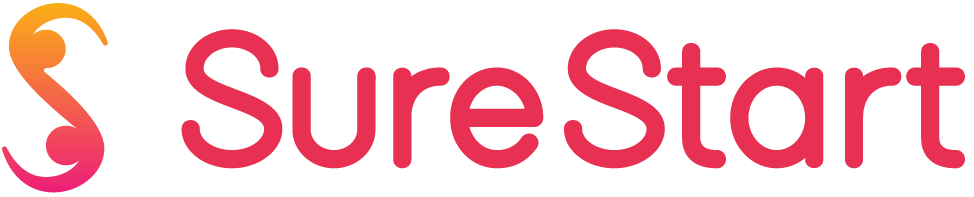

#Day 13 Objectives:
* To acquaint you with the problem of overfit models and to mitigate it with regularization

#Overfitting and Underfitting

**Overfitting** occurs when you achieve a good fit of your model on the training data, while it does not generalize well on new, unseen data. In other words, the model learnt patterns specific to the training data, which are irrelevant in other data.

We can identify overfitting by looking at validation metrics, like loss or accuracy. Usually the validation metric stops improving after a certain number of epochs and begins to decrease afterwards. The training metric continues to improve because the model seeks to find the best fit for the training data.

There are several manners in which we can reduce overfitting in deep learning models. The best option is to get more training data. Unfortunately, in real-world situations you often do not have this possibility due to time, budget or technical constraints.

Another way to reduce overfitting is to lower the capacity of the model to memorize the training data. As such, the model will need to focus on the relevant patterns in the training data, which results in better generalization. In this post we'll discuss three options to achieve this.

**Underfitting** is a scenario where a data model is unable to capture the relationship between the input and output variables accurately, generating a high error rate on both the training set and unseen data.

In [1]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

import nltk
nltk.download('stopwords')

# Packages for modeling
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 20  # Maximum number of words in a sequence

In [3]:
root = Path('../content/')
input_path = root / 'input/' 
ouput_path = root / 'output/'
source_path = root / 'source/'

Now we have dealt with neural networks enough that we do not need to handle them directly so we shall work with helper functions.

## Question 1

You will be dealing with a dataset containing Tweets. You have learned about data cleaning in the past days. How will you "clean" Tweets before trying to learn some patterns from the text?

*Hint*: Check out the helper functions to learn more about data cleaning in language.

The data will be able to be clean with the use of these preprocessed training steps including removing stopwords and getting mentions and deleting them when we are in the space.

#Helper Functions

## Compile a model with losses and weights and train it

Function to train a multi-class model. The number of epochs and 
batch_size are set by the constants at the top of the
notebook. 

Parameters:
* model : model with the chosen architecture
* X_train : training features
* y_train : training target
* X_valid : validation features
* Y_valid : validation target

Output:
* model training history

In [7]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=1)
    return history

## Plot the performance of a model over a chosen metric

Function to evaluate a trained model on a chosen metric. 
Training and validation metric are plotted in a
line chart for each epoch.

Parameters:
* `history`: model training history
* `metric_name`: loss or accuracy

Output:
* line chart with epochs of x-axis and metric on
y-axis

In [9]:
def eval_metric(model, history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    plt.show()

## Test a chosen model on its validation set 

Function to test the model on new data after training it
on the full training data with the optimal number of epochs.

Parameters:

* `model`: trained model

* `X_train`: training features

* `y_train`: training target

* `X_test`: test features

* `y_test`: test target

* `epochs`: optimal number of epochs

Output:

* test accuracy and test loss

In [10]:
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=1)
    results = model.evaluate(X_test, y_test)
    print()
    print('Test accuracy: {0:.2f}%'.format(results[1]*100))
    return results

## Remove stopwords from dataset to make the data cleaner

Function to remove English stopwords from a Pandas Series.

Parameters:
* `input_text`: text to clean

Output:
* cleaned Pandas Series 

In [12]:
def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 

## Removing mentions from tweets

Function to remove mentions, preceded by @, in a Pandas Series

Parameters:
*    `input_text`: text to clean

Output:
*    cleaned Pandas Series 


In [13]:
def remove_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)

## Compare two different models by metrics 

Function to compare a metric between two models 

Parameters:

* `model_hist_1`: training history of model 1

* `model_hist_2`: training history of model 2

* `metric`: metric to compare, loss, acc, val_loss or val_acc

Output:
* plot of metrics of both models

In [14]:
def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]

    e = range(1, NB_START_EPOCHS + 1)
    
    metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss'
    }
    
    metric_label = metrics_dict[metric]

    plt.plot(e, metric_model_1, 'bo', label=model_1.name)
    plt.plot(e, metric_model_2, 'b', label=model_2.name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()

## Calculating the epoch at which the loss is at its minimum
   
Function to return the epoch number where the validation loss is
at its minimum
    
Parameters:
*        `model_hist`: training history of model

Output: 
* epoch number with minimum validation loss

In [15]:
def optimal_epoch(model_hist):
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

#Data preparation


In [18]:
! gdown --id 1QFupRVBpstzf_D6NiFvYQIO-MPuiwG9u 
! mkdir input/ 
! mv Tweets.csv input/

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1QFupRVBpstzf_D6NiFvYQIO-MPuiwG9u
To: /content/Tweets.csv
100% 3.42M/3.42M [00:00<00:00, 181MB/s]
mkdir: cannot create directory ‘input/’: File exists


## Data cleaning
We load the csv with the tweets and perform a random shuffle. It's a good practice to shuffle the data before splitting between a train and test set. That way the sentiment classes are equally distributed over the train and test sets. We'll only keep the text column as input and the airline_sentiment column as the target.

The next thing we will do is removing stopwords. Stopwords do not have any value for predicting the sentiment. Furthermore, as we want to build a model that can be used for other airline companies as well, we remove the mentions.

In [20]:
df = pd.read_csv(input_path / 'Tweets.csv')
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)

## Train-Test split
The evaluation of the model performance needs to be done on a separate test set. As such, we can estimate how well the model generalizes. This is done with the train_test_split method of scikit-learn.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 13176
# Test data samples: 1464


## Converting words to numbers
To use the text as input for a model, we first need to convert the words into tokens, which simply means converting the words to integers that refer to an index in a dictionary. Here we will only keep the most frequent words in the training set.

We clean up the text by applying filters and putting the words to lowercase. Words are separated by spaces.



In [22]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               char_level=False,
               split=' ')
tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 13176 documents
10000 words in dictionary
Top 5 most common words are: [('flight', 3506), ('not', 1419), ('no', 1361), ('get', 1200), ('t', 1113)]


After having created the dictionary we can convert the text of a tweet to a vector with `NB_WORDS` values. With `mode=binary`, it contains an indicator whether the word appeared in the tweet or not. This is done with the texts_to_matrix method of the Tokenizer.

In [23]:
X_train_oh = tk.texts_to_matrix(X_train, mode='binary')
X_test_oh = tk.texts_to_matrix(X_test, mode='binary')

## Converting the target classes to numbers
We need to convert the target classes to numbers as well, which in turn are one-hot-encoded with the to_categorical method in Keras


In [24]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"neutral" is converted into 0
"0" is converted into [1. 0. 0.]


## Splitting off a validation set
Now that our data is ready, we split off a validation set. This validation set will be used to evaluate the model performance when we tune the parameters of the model.

In [27]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (1318, 10000)


# Bias and Variance

*Bias* and *variance* are two terms you need to get used to if constructing statistical models, such as those in machine learning. There is a tension between wanting to construct a model which is complex enough to capture the system that we are modelling, but not so complex that we start to fit to noise in the training data. This is related to underfitting and overfitting of a model to data, and back to the bias-variance tradeoff.

If we have an *underfitted* model, this means that we do not have enough parameters to capture the trends in the underlying system. Imagine for example that we have data that is parabolic in nature, but we try to fit this with a linear function, with just one parameter. Because the function does not have the required complexity to fit the data (two parameters), we end up with a poor predictor. In this case the model will have high bias. This means that we will get consistent answers, but consistently wrong answers.

If we have overfitted, this means that we have too many parameters to be justified by the actual underlying data and therefore build an overly complex model. Again imagine that the true system is a parabola, but we used a higher order polynomial to fit to it. Because we have natural noise in the data used to fit (deviations from the perfect parabola), the overly complex model treats these fluctuations and noise as if they were intrinsic properties of the system and attempts to fit to them. The result is a model that has high variance. This means that we will not get consistent predictions of future results.

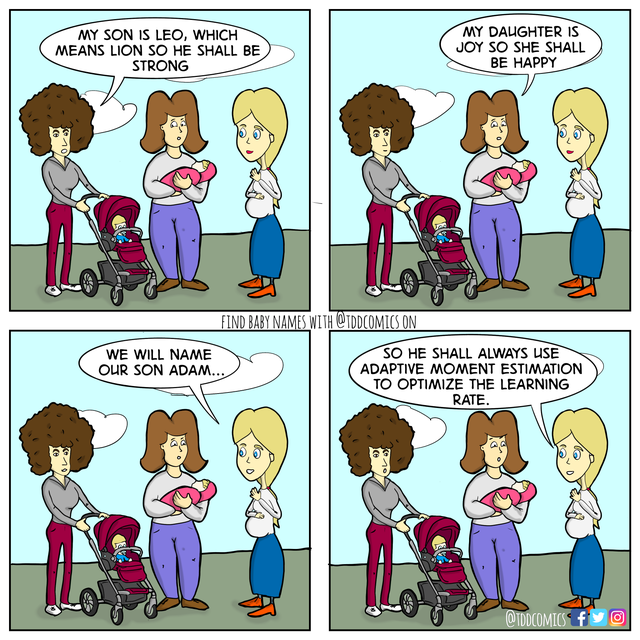

#Creating a model that overfits
We start with a model that overfits. It has 2 densely connected layers of 64 elements. The input_shape for the first layer is equal to the number of words we kept in the dictionary and for which we created one-hot-encoded features.

As we need to predict 3 different sentiment classes, the last layer has 3 elements. The softmax activation function makes sure the three probabilities sum up to 1.

The number of parameters to train is computed as (nb inputs x nb elements in hidden layer) + nb bias terms. The number of inputs for the first layer equals the number of words in our corpus. The subsequent layers have the number of outputs of the previous layer as inputs. So the number of parameters per layer are:

* First layer : (10000 x 64) + 64 = 640064
* Second layer : (64 x 64) + 64 = 4160
* Last layer : (64 x 3) + 3 = 195

In [28]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640064    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


Because this project is a multi-class, single-label prediction, we use categorical_crossentropy as the loss function and softmax as the final activation function. We fit the model on the train data and validate on the validation set. We run for a predetermined number of epochs and will see when the model starts to overfit.

In [29]:
base_history = deep_model(base_model, X_train_rest, y_train_rest, X_valid, y_valid)
base_min = optimal_epoch(base_history)

Epoch 1/20
24/24 [==============================] - 2s 48ms/step - loss: 0.8360 - accuracy: 0.6289 - val_loss: 0.6872 - val_accuracy: 0.6950
Epoch 2/20
24/24 [==============================] - 1s 40ms/step - loss: 0.5546 - accuracy: 0.7883 - val_loss: 0.5466 - val_accuracy: 0.7838
Epoch 3/20
24/24 [==============================] - 1s 40ms/step - loss: 0.4052 - accuracy: 0.8632 - val_loss: 0.5274 - val_accuracy: 0.7845
Epoch 4/20
24/24 [==============================] - 1s 41ms/step - loss: 0.3202 - accuracy: 0.8888 - val_loss: 0.5248 - val_accuracy: 0.7929
Epoch 5/20
24/24 [==============================] - 1s 40ms/step - loss: 0.2613 - accuracy: 0.9071 - val_loss: 0.5442 - val_accuracy: 0.7891
Epoch 6/20
24/24 [==============================] - 1s 40ms/step - loss: 0.2174 - accuracy: 0.9223 - val_loss: 0.5835 - val_accuracy: 0.7731
Epoch 7/20
24/24 [==============================] - 1s 40ms/step - loss: 0.1822 - accuracy: 0.9361 - val_loss: 0.6292 - val_accuracy: 0.7906
Epoch 8/20
24

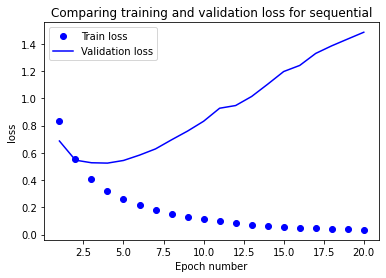

In [30]:
eval_metric(base_model, base_history, 'loss')


In the beginning the validation loss goes down. But at epoch 3 this stops and the validation loss starts increasing rapidly. This is when the models begins to overfit.

The training loss continues to go down and almost reaches zero at epoch 20. This is normal as the model is trained to fit the train data as good as possible.

## Question 2

Intuitively, what kind of model would have underfitted the Tweets dataset? Define the model architecture below.

### Answer 2

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 1)                 10001     
                                                                 
 dense_37 (Dense)            (None, 1)                 2         
                                                                 
 dense_38 (Dense)            (None, 3)                 6         
                                                                 
Total params: 10,009
Trainable params: 10,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
24/24 [==============================] - 1s 18ms/step - loss: 1.0811 - accuracy: 0.6155 - val_loss: 1.0666 - val_accuracy: 0.6184
Epoch 2/20
24/24 [==============================] - 0s 13ms/step - loss: 1.0530 - accuracy: 0.6253 - val_loss: 1.0418 - val_accuracy: 0.6184
Epoch 3/20
24/24 [=============

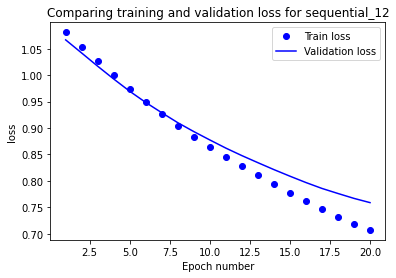

In [44]:
model = models.Sequential()
model.add(layers.Dense(1, activation='relu', input_shape=(NB_WORDS,)))
model.add(layers.Dense(1, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.summary()
base_history = deep_model(model, X_train_rest, y_train_rest, X_valid, y_valid)
base_min = optimal_epoch(base_history)
eval_metric(model, base_history, 'loss')

## Question 3

In case of underfitting, what is the behavior of the training/testing loss vs epoch curve?

The training and testing loss is decreasing as there is a total number of epochs that increases which makes a downward curve on the dataset for the graph.

## Handling overfitting
Now, we can try to do something about the overfitting. There are different options to do that.

* Option 1: reduce the network's capacity by removing layers or reducing the number of elements in the hidden layers
* Option 2: apply regularization, which comes down to adding a cost to the loss function for large weights
* Option 3: use Dropout layers, which will randomly remove certain features by setting them to zero

## Question 4

From the regularization methods we have used as of yet, what are the main takeaways on reducing underfitting and reducing overfitting?

There are many ways to reduce overfitting, including the layer or the elements are removed to reduce the capacity of layers and the algorithm, and using dropout layers to randomly remove those specific features and the layer. To reduce underfitting, you may add more layers and increase the number of elements in these given parts of the hidden layers.

## Reducing the network's capacity
Our first model has a large number of trainable parameters. The higher this number, the easier the model can memorize the target class for each training sample. Obviously, this is not ideal for generalizing on new data.

By lowering the capacity of the network, you force it to learn the patterns that matter, or that minimize the loss. On the other hand, reducing the network's capacity too much, will lead to underfitting. The model will not be able to learn the relevant patterns in the train data.

We reduce the network's capacity by removing one hidden layer and lowering the number of elements in the remaining layer to 16.

In [45]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(16, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 16)                160016    
                                                                 
 dense_40 (Dense)            (None, 3)                 51        
                                                                 
Total params: 160,067
Trainable params: 160,067
Non-trainable params: 0
_________________________________________________________________


In [46]:
reduced_history = deep_model(reduced_model, X_train_rest, y_train_rest, X_valid, y_valid)
reduced_min = optimal_epoch(reduced_history)

Epoch 1/20
24/24 [==============================] - 1s 34ms/step - loss: 1.0250 - accuracy: 0.6190 - val_loss: 0.9593 - val_accuracy: 0.6631
Epoch 2/20
24/24 [==============================] - 1s 26ms/step - loss: 0.8916 - accuracy: 0.7086 - val_loss: 0.8542 - val_accuracy: 0.7071
Epoch 3/20
24/24 [==============================] - 1s 25ms/step - loss: 0.7756 - accuracy: 0.7505 - val_loss: 0.7644 - val_accuracy: 0.7291
Epoch 4/20
24/24 [==============================] - 1s 25ms/step - loss: 0.6771 - accuracy: 0.7871 - val_loss: 0.6942 - val_accuracy: 0.7420
Epoch 5/20
24/24 [==============================] - 1s 25ms/step - loss: 0.5977 - accuracy: 0.8112 - val_loss: 0.6414 - val_accuracy: 0.7557
Epoch 6/20
24/24 [==============================] - 1s 25ms/step - loss: 0.5348 - accuracy: 0.8326 - val_loss: 0.6043 - val_accuracy: 0.7693
Epoch 7/20
24/24 [==============================] - 1s 26ms/step - loss: 0.4842 - accuracy: 0.8490 - val_loss: 0.5749 - val_accuracy: 0.7815
Epoch 8/20
24

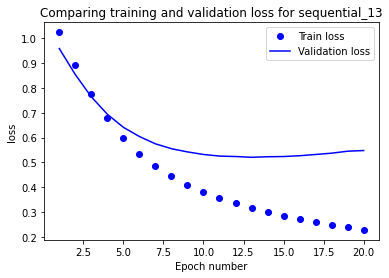

In [47]:
eval_metric(reduced_model, reduced_history, 'loss')

We can see that it takes more epochs before the reduced model starts overfitting. The validation loss also goes up slower than our first model.



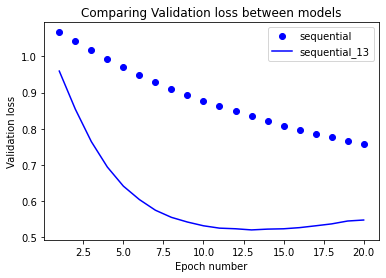

In [48]:
compare_models_by_metric(base_model, reduced_model, base_history, reduced_history, 'val_loss')

When we compare the validation loss of the baseline model, it is clear that the reduced model starts overfitting at a later epoch. The validation loss stays lower much longer than the baseline model.



# Applying regularization

You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights-one reason why L2 is more common.

In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.


In [49]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 64)                640064    
                                                                 
 dense_42 (Dense)            (None, 64)                4160      
                                                                 
 dense_43 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [50]:
reg_history = deep_model(reg_model, X_train_rest, y_train_rest, X_valid, y_valid)
reg_min = optimal_epoch(reg_history)

Epoch 1/20
24/24 [==============================] - 2s 49ms/step - loss: 0.9399 - accuracy: 0.6289 - val_loss: 0.7758 - val_accuracy: 0.7011
Epoch 2/20
24/24 [==============================] - 1s 41ms/step - loss: 0.6680 - accuracy: 0.7716 - val_loss: 0.6558 - val_accuracy: 0.7663
Epoch 3/20
24/24 [==============================] - 1s 42ms/step - loss: 0.5486 - accuracy: 0.8388 - val_loss: 0.6169 - val_accuracy: 0.7898
Epoch 4/20
24/24 [==============================] - 1s 42ms/step - loss: 0.4859 - accuracy: 0.8615 - val_loss: 0.6284 - val_accuracy: 0.7883
Epoch 5/20
24/24 [==============================] - 1s 42ms/step - loss: 0.4484 - accuracy: 0.8756 - val_loss: 0.6209 - val_accuracy: 0.7883
Epoch 6/20
24/24 [==============================] - 1s 42ms/step - loss: 0.4184 - accuracy: 0.8869 - val_loss: 0.6436 - val_accuracy: 0.7936
Epoch 7/20
24/24 [==============================] - 1s 42ms/step - loss: 0.3968 - accuracy: 0.8969 - val_loss: 0.6481 - val_accuracy: 0.7951
Epoch 8/20
24

For the regularized model we notice that it starts overfitting in the same epoch as the baseline model. However, the loss increases much slower afterwards.



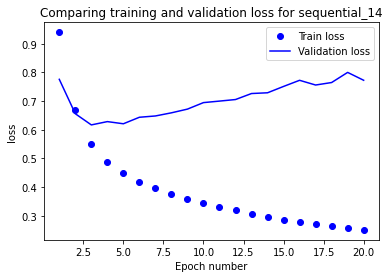

In [51]:
eval_metric(reg_model, reg_history, 'loss')

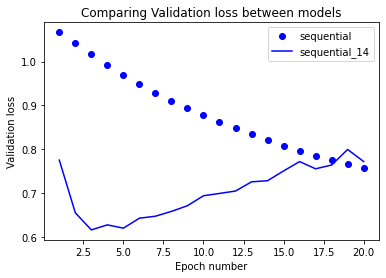

In [52]:
compare_models_by_metric(base_model, reg_model, base_history, reg_history, 'val_loss')

## Question 5

First identify (provide the name of) and then code the regularizer which is used in the following loss function:

$$cost = (\mathbf{y} - \mathbf{x}W)^2 + λ||W||$$

Let's assume $w = [-5, 4, -3, 2, 1]$

###  Answer 5

In [64]:
weights = [-5, 4, -3, 2, 1]

def l1_norm(weights):
    reg = np.sum(np.abs(weights))
    return reg

print(l1_norm(weights))

15


## Question 6

First identify (provide the name of) and then code the regularizer which is used in the following loss function:

$$cost = (\mathbf{y} - \mathbf{x}W)^2 + λ||W||_2^2$$

Let's assume $w = [-5, 4, -3, 2, 1]$

###  Answer 6

In [102]:
weights = [-5, 4, -3, 2, 1]

def l2_norm(weights):
    reg = np.sqrt(np.sum(np.abs(weights) ** 2))
    return reg

print(l2_norm(weights))

7.416198487095663


## Adding dropout layers
Add dropout
Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 1.3, 0, 1.1].

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In `tf.keras` you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before.

Let's add two Dropout layers in our network to see how well they do at reducing overfitting:

In [72]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_model.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 64)                640064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_45 (Dense)            (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_46 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [73]:
drop_history = deep_model(drop_model, X_train_rest, y_train_rest, X_valid, y_valid)
drop_min = optimal_epoch(drop_history)

Epoch 1/20
24/24 [==============================] - 2s 49ms/step - loss: 0.8949 - accuracy: 0.6150 - val_loss: 0.7699 - val_accuracy: 0.6259
Epoch 2/20
24/24 [==============================] - 1s 41ms/step - loss: 0.7169 - accuracy: 0.6639 - val_loss: 0.6669 - val_accuracy: 0.7086
Epoch 3/20
24/24 [==============================] - 1s 42ms/step - loss: 0.6049 - accuracy: 0.7664 - val_loss: 0.5856 - val_accuracy: 0.7731
Epoch 4/20
24/24 [==============================] - 1s 42ms/step - loss: 0.5181 - accuracy: 0.8166 - val_loss: 0.5567 - val_accuracy: 0.7731
Epoch 5/20
24/24 [==============================] - 1s 42ms/step - loss: 0.4541 - accuracy: 0.8403 - val_loss: 0.5314 - val_accuracy: 0.7906
Epoch 6/20
24/24 [==============================] - 2s 69ms/step - loss: 0.4019 - accuracy: 0.8576 - val_loss: 0.5489 - val_accuracy: 0.7959
Epoch 7/20
24/24 [==============================] - 1s 58ms/step - loss: 0.3621 - accuracy: 0.8737 - val_loss: 0.5503 - val_accuracy: 0.7997
Epoch 8/20
24

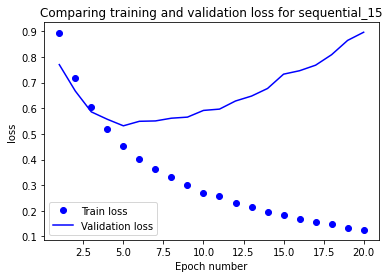

In [74]:
eval_metric(drop_model, drop_history, 'loss')


The model with dropout layers starts overfitting later than the baseline model. The loss also increases slower than the baseline model.



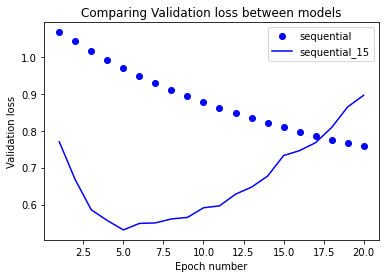

In [75]:
compare_models_by_metric(base_model, drop_model, base_history, drop_history, 'val_loss')


The model with the Dropout layers starts overfitting later. Compared to the baseline model the loss also remains much lower.



## Combined L2 + dropout

In [81]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu', input_shape=(NB_WORDS,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3)
])


In [82]:
combined_history = deep_model(combined_model, X_train_rest, y_train_rest, X_valid, y_valid)
combined_min = optimal_epoch(combined_history)

Epoch 1/20
24/24 [==============================] - 8s 275ms/step - loss: 1.3194 - accuracy: 0.6068 - val_loss: 1.0819 - val_accuracy: 0.6904
Epoch 2/20
24/24 [==============================] - 8s 321ms/step - loss: 4.3811 - accuracy: 0.7017 - val_loss: 8.3032 - val_accuracy: 0.7276
Epoch 3/20
24/24 [==============================] - 6s 264ms/step - loss: 6.1064 - accuracy: 0.7485 - val_loss: 9.2298 - val_accuracy: 0.7420
Epoch 4/20
24/24 [==============================] - 6s 264ms/step - loss: 5.9326 - accuracy: 0.7738 - val_loss: 8.6085 - val_accuracy: 0.7375
Epoch 5/20
24/24 [==============================] - 6s 265ms/step - loss: 7.1266 - accuracy: 0.7651 - val_loss: 6.9676 - val_accuracy: 0.7132
Epoch 6/20
24/24 [==============================] - 7s 273ms/step - loss: 7.4284 - accuracy: 0.7302 - val_loss: 10.1393 - val_accuracy: 0.6184
Epoch 7/20
24/24 [==============================] - 7s 296ms/step - loss: 7.6270 - accuracy: 0.6334 - val_loss: 1.3135 - val_accuracy: 0.7284
Epoch

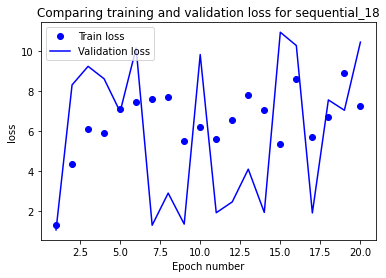

In [83]:
eval_metric(combined_model, combined_history, 'loss')


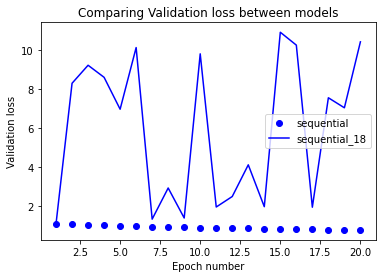

In [84]:
compare_models_by_metric(base_model, combined_model, base_history, combined_history, 'val_loss')


## Question 7

When does it make sense to add both L2 regularization and Dropout?

And what did doing so achieve in this case?

You can add the layers for L2 regularization and dropout when the model is overfitting, and adding both caused variability.

#Training on the full train data and evaluation on test data
At first sight the reduced model seems to be the best model for generalization. But let's check that on the test set.

In [85]:
base_results = test_model(base_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, base_min)


Epoch 1/20
26/26 [==============================] - 1s 40ms/step - loss: 0.5049 - accuracy: 0.8325
Epoch 2/20
26/26 [==============================] - 1s 39ms/step - loss: 0.3490 - accuracy: 0.9726
Epoch 3/20
26/26 [==============================] - 1s 39ms/step - loss: 0.2295 - accuracy: 0.9762
Epoch 4/20
26/26 [==============================] - 1s 38ms/step - loss: 0.1513 - accuracy: 0.9794
Epoch 5/20
26/26 [==============================] - 1s 39ms/step - loss: 0.1080 - accuracy: 0.9810
Epoch 6/20
26/26 [==============================] - 1s 38ms/step - loss: 0.0874 - accuracy: 0.9830
Epoch 7/20
26/26 [==============================] - 1s 38ms/step - loss: 0.0765 - accuracy: 0.9838
Epoch 8/20
26/26 [==============================] - 1s 38ms/step - loss: 0.0729 - accuracy: 0.9848
Epoch 9/20
26/26 [==============================] - 1s 39ms/step - loss: 0.0679 - accuracy: 0.9853
Epoch 10/20
26/26 [==============================] - 1s 39ms/step - loss: 0.0634 - accuracy: 0.9865
Epoch 11/

In [86]:
reduced_results = test_model(reduced_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reduced_min)


Epoch 1/13
26/26 [==============================] - 1s 22ms/step - loss: 0.2518 - accuracy: 0.9137
Epoch 2/13
26/26 [==============================] - 1s 24ms/step - loss: 0.2404 - accuracy: 0.9167
Epoch 3/13
26/26 [==============================] - 1s 24ms/step - loss: 0.2303 - accuracy: 0.9199
Epoch 4/13
26/26 [==============================] - 1s 23ms/step - loss: 0.2208 - accuracy: 0.9254
Epoch 5/13
26/26 [==============================] - 1s 25ms/step - loss: 0.2121 - accuracy: 0.9282
Epoch 6/13
26/26 [==============================] - 1s 23ms/step - loss: 0.2038 - accuracy: 0.9319
Epoch 7/13
26/26 [==============================] - 1s 23ms/step - loss: 0.1962 - accuracy: 0.9340
Epoch 8/13
26/26 [==============================] - 1s 23ms/step - loss: 0.1888 - accuracy: 0.9386
Epoch 9/13
26/26 [==============================] - 1s 23ms/step - loss: 0.1820 - accuracy: 0.9409
Epoch 10/13
26/26 [==============================] - 1s 23ms/step - loss: 0.1753 - accuracy: 0.9423
Epoch 11/

In [87]:
reg_results = test_model(reg_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reg_min)


Epoch 1/3
26/26 [==============================] - 1s 41ms/step - loss: 0.2994 - accuracy: 0.9387
Epoch 2/3
26/26 [==============================] - 1s 41ms/step - loss: 0.2737 - accuracy: 0.9470
Epoch 3/3
46/46 [==============================] - 0s 3ms/step - loss: 0.7367 - accuracy: 0.7917

Test accuracy: 79.17%


In [88]:
drop_results = test_model(drop_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, drop_min)


Epoch 1/5
26/26 [==============================] - 1s 41ms/step - loss: 0.2005 - accuracy: 0.9422
Epoch 2/5
26/26 [==============================] - 1s 39ms/step - loss: 0.1731 - accuracy: 0.9479
Epoch 3/5
26/26 [==============================] - 1s 39ms/step - loss: 0.1629 - accuracy: 0.9499
Epoch 4/5
26/26 [==============================] - 1s 40ms/step - loss: 0.1492 - accuracy: 0.9551
Epoch 5/5
46/46 [==============================] - 0s 2ms/step - loss: 0.8064 - accuracy: 0.7944

Test accuracy: 79.44%


# Handling Underfitting
* In a general situation, the best strategy is to increase the model complexity by either increasing the number of parameters of your deep learning model or the order of your model. Underfitting is due to the model being simpler than needed. It fails to capture the patterns in the data. Increasing the model complexity will lead to improvement in training performance. If we use a large enough model it can even achieve a training error of zero i.e. the model will memorize the data and suffer from over-fitting. The goal is to hit the optimal sweet spot.
* Try to train the model for more epochs. Ensure that the loss is decreasing gradually over the course of the training. Otherwise, it is highly likely that there is some kind of bug or problem in the training code/logic itself.
* If you aren’t shuffling the data after every epoch, it can harm the model performance. Ensuring that you are shuffling the data is a good check to perform at this point.

#Conclusion
To recap: here are the most common ways to prevent overfitting in neural networks:

* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

Two important approaches not covered in this guide are:

* data-augmentation
* batch normalization

Remember that each method can help on its own, but often combining them can be even more effective.

here are the ways to prevent underfitting

* Get more training data.
* Increase the size or number of parameters in the model.
* Increase the complexity of the model.
* Increasing the training time, until cost function is minimised.


# Bonus content - Visualizing L2 regularization


In [89]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
import itertools

In [90]:
def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i,j in itertools.product(range(resolution), range(resolution)):
        zg[i,j] = f([xg[i,j], yg[i,j]])
    ax.contour(xg, yg, zg, 100)
    return ax

Let's create a toy data:

In [91]:
N = 20
x = np.random.rand(N) * 10
y = -4*x + 10 + 2*np.random.randn(N)

visualize the regularized **cost function** 

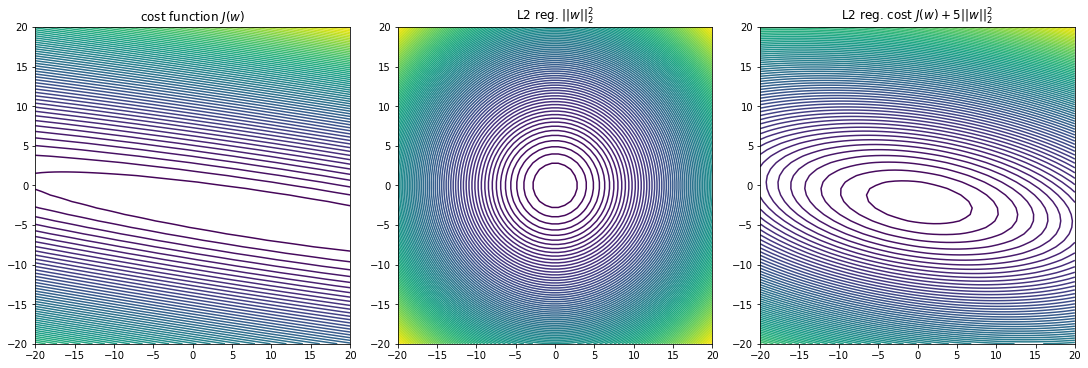

In [92]:
cost = lambda w: .5*np.mean((w[0] + w[1]*x - y)**2)
l2_penalty = lambda w: np.dot(w,w)/2
cost_plus_l2 = lambda w: cost(w) + 5*l2_penalty(w)

fig, axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(15, 5))
plot_contour(cost, [-20,20], [-20,20], 50, axes[0])
axes[0].set_title(r'cost function $J(w)$')
plot_contour(l2_penalty, [-20,20], [-20,20], 50, axes[1])
axes[1].set_title(r'L2 reg. $||w||_2^2$')
plot_contour(cost_plus_l2, [-20,20], [-20,20], 50, axes[2])
axes[2].set_title(r'L2 reg. cost $J(w) + 5 ||w||_2^2$')
plt.show()

## Bonus question: Plot the same for L1 regularization 

### Answer 

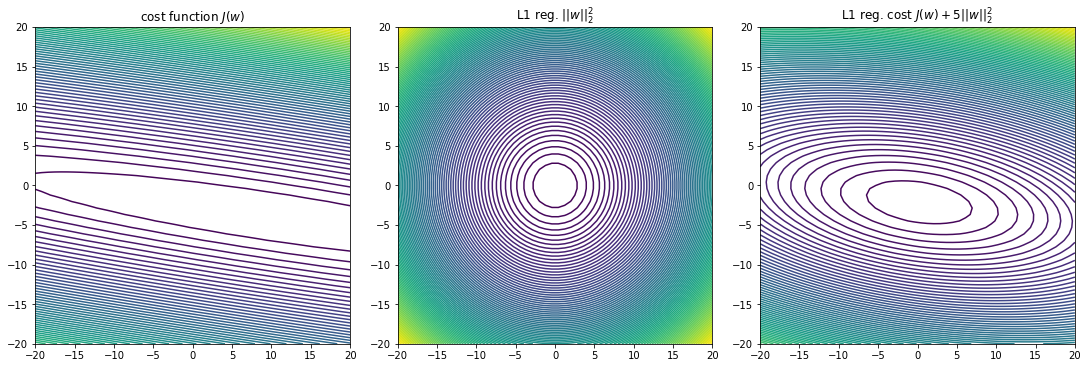

In [119]:
cost = lambda w: .5*np.mean((w[0] + w[1]*x - y)**2)
l1_penalty = lambda w: np.dot(w, w)/2
cost_plus_l1= lambda w: cost(w) + 5*l1_penalty(w)

fig, axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(15, 5))
plot_contour(cost, [-20,20], [-20,20], 50, axes[0])
axes[0].set_title(r'cost function $J(w)$')
plot_contour(l1_penalty, [-20,20], [-20,20], 50, axes[1])
axes[1].set_title(r'L1 reg. $||w||_2^2$')
plot_contour(cost_plus_l1, [-20,20], [-20,20], 50, axes[2])
axes[2].set_title(r'L1 reg. cost $J(w) + 5 ||w||_2^2$')
plt.show()

## Bonus Question 2
After looking at the visualization to what the L1 and L2 normalizations, how do they help while training?

The visualizations showed the cost functions and this helps these various elements in the algorithm to check underfitting or overfitting and take measures to reduce the bias in the training elements and increase the accuracy observed.

# **Upload this Day 13 Colab Notebook to your Github repository under "Day 13" folder. Also add your *Reflection* on today's learning in README.md**

Source: https://towardsdatascience.com/handling-overfitting-in-deep-learning-models-c760ee047c6e